In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(style='darkgrid')
from copy import deepcopy
from torchvision import transforms
def print_np(x):
    print('(1) Type is %s' %(type(x)))
    print('(2) Shape is %s' %(x.shape,))
#     print('(3) Values are : \n%s' %(x))

In [2]:
from gpr import kernel_se, gpr

## data generation

In [3]:
# data (no noise)
x_data = np.linspace(-8,8,200).reshape((-1,1))
y_data = np.cos(np.pi/2*x_data)*np.exp(-(x_data/4)**2) 
# train (add noise)
# N_train = 50
x_train = np.vstack((np.linspace(-6,-2.5,90).reshape((-1,1)),np.linspace(-1.5,6,150).reshape((-1,1)) ))
y_train = np.cos(np.pi/2*x_train)*np.exp(-(x_train/4)**2) + 0.1*np.random.randn(*np.shape(x_train))
y_train += 0.5*np.random.randn(*np.shape(x_train)) * np.logical_and(x_train > 1,x_train < 3)

def plot_vline() :
    alpha = 0.3
    plt.vlines(-6, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(-2.5, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(-1.5, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(1, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(3, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(6, -2, 2, colors='k', linestyles='--',alpha=alpha)
    
    plt.text(-7.8, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(-2.7, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(6.1, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(1.1, -1.5, 'Heteroscedastic',fontsize=15,color='g')
    plt.text(1.1, -1.7, 'aleatoric',fontsize=15,color='g')

Text(0.5, 1.0, 'Training Data for a Regression Task')

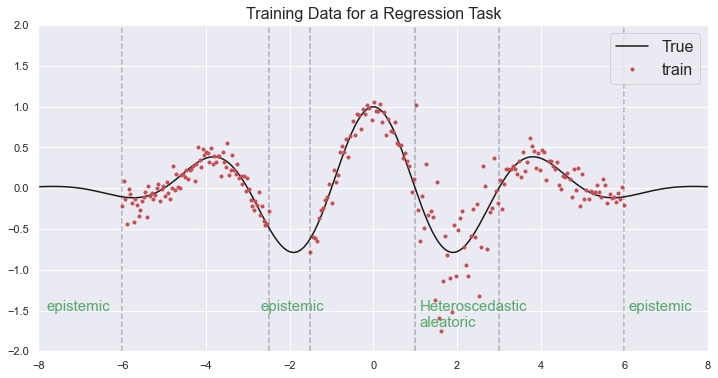

In [4]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')

plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

## Gaussian process regression

In [5]:
# Do inference
hyp={'gain':5,'len':1./1.,'s2w':1e-2*5}
GPR = gpr(_xTr=x_train,_yTr=y_train,_hyp=hyp)
y_pred, y_sigma_pred = GPR.inference(_xTe=x_data)
y_sigma_pred = y_sigma_pred.reshape((-1,1))

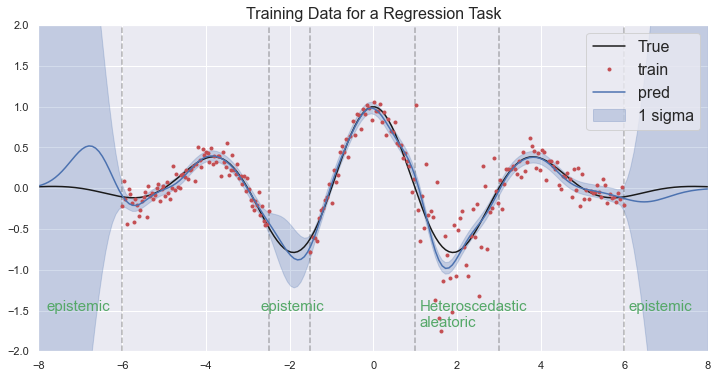

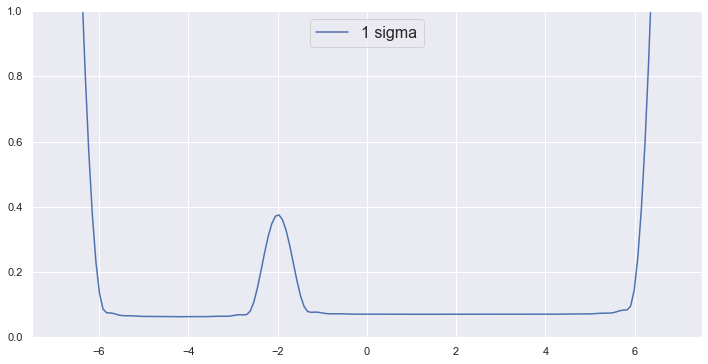

In [6]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred[:,0]+y_sigma_pred[:,0],
                 y_pred[:,0]-y_sigma_pred[:,0],color='b',alpha=.25,label='1 sigma')

plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-7.5,7.5,0.0,1.0])
plt.plot(x_data,y_sigma_pred,'b',label='1 sigma')
plt.legend(fontsize=16)

# Neural Net

In [7]:
import torch
from datasetter import SimpleDataset
from transformer import FloatToTensor
from trainer import RegressionTrainer
from models import LinearNN
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

In [8]:
transform = transforms.Compose([
            FloatToTensor(),
        ])

In [9]:
# TODO : normalization

In [10]:
datasets = {}
datasets['train'] = SimpleDataset(x_train,y_train,np.shape(x_train)[0],transform)
datasets['valid'] = SimpleDataset(x_data,y_data,np.shape(x_data)[0],transform)

In [11]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],batch_size=128,shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],batch_size=len(x_train),shuffle=True)

In [12]:
num_hidden = 100
model = LinearNN(num_hidden,drop_prob=0.2)
print(model)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.MSELoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


In [13]:
LinearNN_trainer = RegressionTrainer('hello')

In [14]:
LinearNN_trainer.train_model(model,criterion,optimizer,scheduler,500,dataloaders,False)

Epoch 0/499
----------
train loss is 0.0101
valid loss is 0.0033

Epoch 1/499
----------
train loss is 0.0039
valid loss is 0.0021

Epoch 2/499
----------
train loss is 0.0031
valid loss is 0.0016

Epoch 3/499
----------
train loss is 0.0028
valid loss is 0.0011

Epoch 4/499
----------
train loss is 0.0022
valid loss is 0.0011

Epoch 5/499
----------
train loss is 0.0021
valid loss is 0.0010

Epoch 6/499
----------
train loss is 0.0021
valid loss is 0.0011

Epoch 7/499
----------
train loss is 0.0021
valid loss is 0.0009

Epoch 8/499
----------
train loss is 0.0019
valid loss is 0.0009

Epoch 9/499
----------
train loss is 0.0019
valid loss is 0.0008

Epoch 10/499
----------
train loss is 0.0018
valid loss is 0.0008

Epoch 11/499
----------
train loss is 0.0018
valid loss is 0.0008

Epoch 12/499
----------
train loss is 0.0017
valid loss is 0.0007

Epoch 13/499
----------
train loss is 0.0018
valid loss is 0.0007

Epoch 14/499
----------
train loss is 0.0017
valid loss is 0.0007

Epoch

train loss is 0.0007
valid loss is 0.0003

Epoch 128/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 129/499
----------
train loss is 0.0008
valid loss is 0.0003

Epoch 130/499
----------
train loss is 0.0008
valid loss is 0.0003

Epoch 131/499
----------
train loss is 0.0006
valid loss is 0.0003

Epoch 132/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 133/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 134/499
----------
train loss is 0.0008
valid loss is 0.0003

Epoch 135/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 136/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 137/499
----------
train loss is 0.0008
valid loss is 0.0003

Epoch 138/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 139/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 140/499
----------
train loss is 0.0007
valid loss is 0.0003

Epoch 141/499
----------
train loss is 0.0006
valid loss is 0.0003

Epoch

valid loss is 0.0002

Epoch 260/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 261/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 262/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 263/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 264/499
----------
train loss is 0.0006
valid loss is 0.0003

Epoch 265/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 266/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 267/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 268/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 269/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 270/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 271/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 272/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 273/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 274/499
----------
t

train loss is 0.0005
valid loss is 0.0002

Epoch 386/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 387/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 388/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 389/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 390/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 391/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 392/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 393/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 394/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 395/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 396/499
----------
train loss is 0.0006
valid loss is 0.0002

Epoch 397/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 398/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 399/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch

LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [15]:
model.eval()
y_pred = model(torch.from_numpy(x_data).float()).detach().numpy()

Text(0.5, 1.0, 'Training Data for a Regression Task')

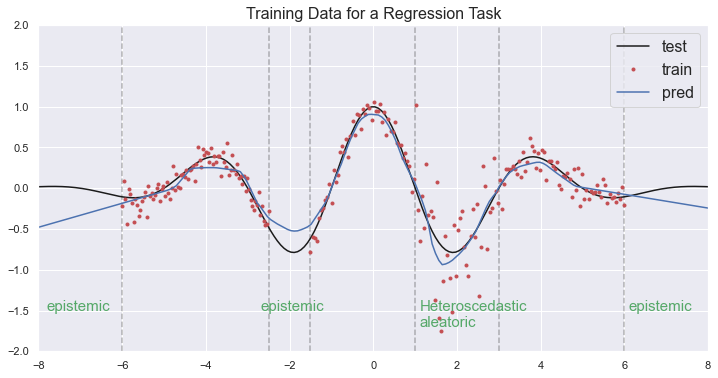

In [16]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='test',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

# Bayesian NN by dropout

In [17]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()
model.eval()
model.apply(apply_dropout)

LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [18]:
N_samples = 20
y_pred_list = np.zeros((len(x_data),N_samples))
for i in range(N_samples) :
    y_pred_list[:,i] = np.squeeze(model(torch.from_numpy(x_data).float()).detach().numpy())
print_np(y_pred_list)

(1) Type is <class 'numpy.ndarray'>
(2) Shape is (200, 20)


In [19]:
y_pred_mean = np.mean(y_pred_list,axis=1)
y_pred_sigma = np.sqrt(np.var(y_pred_list,axis=1))
y_pred_mean = np.expand_dims(y_pred_mean,1)
y_pred_sigma = np.expand_dims(y_pred_sigma,1)
print_np(y_pred_sigma)

(1) Type is <class 'numpy.ndarray'>
(2) Shape is (200, 1)


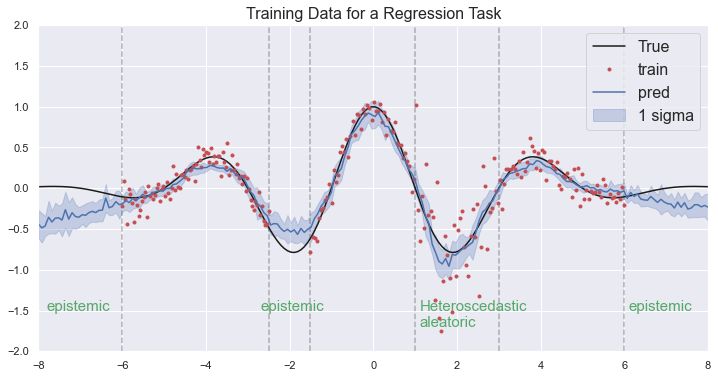

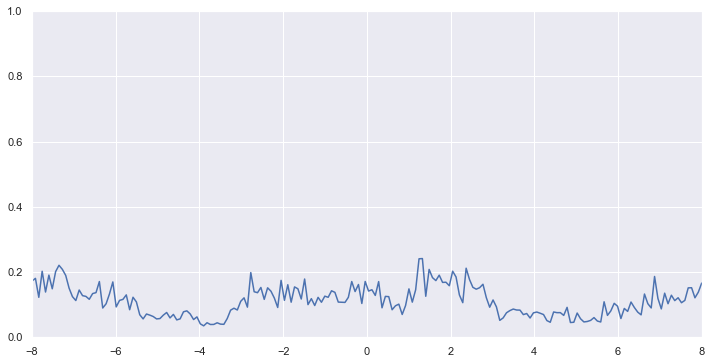

In [20]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred_mean,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred_mean[:,0]+y_pred_sigma[:,0],
                 y_pred_mean[:,0]-y_pred_sigma[:,0],color='b',alpha=.25,label='1 sigma')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-8,8,0.0,1.0])
plt.plot(x_data,y_pred_sigma,'b',label='pred')

# Density network for aleatoric uncertainty

In [21]:
import torch
from datasetter import SimpleDataset
from transformer import FloatToTensor
from trainer import RegDensityTrainer
from models import LinearDensityNN
from utils import mdn_loss
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

In [22]:
datasets = {}
datasets['train'] = SimpleDataset(x_train,y_train,np.shape(x_train)[0],transform)
datasets['valid'] = SimpleDataset(x_data,y_data,np.shape(x_data)[0],transform)

In [23]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],batch_size=32,shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],batch_size=len(x_train),shuffle=True)

In [24]:
num_hidden = 50
model = LinearDensityNN(num_hidden,drop_prob=0.0)
print(model)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = None
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

LinearDensityNN(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3_1): Linear(in_features=50, out_features=1, bias=True)
  (fc3_2): Linear(in_features=50, out_features=1, bias=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)


In [29]:
DensityNN_trainer = RegDensityTrainer('hello')

In [30]:
DensityNN_trainer.train_model(model,criterion,optimizer,scheduler,500,dataloaders,False)

Epoch 0/499
----------
train loss is -1.4288
valid loss is 2.1157

Epoch 1/499
----------
train loss is -1.4362
valid loss is 3.7210

Epoch 2/499
----------
train loss is -1.4236
valid loss is 5.1028

Epoch 3/499
----------
train loss is -1.3851
valid loss is 0.4587

Epoch 4/499
----------
train loss is -1.3886
valid loss is 3.0876

Epoch 5/499
----------
train loss is -1.4040
valid loss is -0.2149

Epoch 6/499
----------
train loss is -1.4274
valid loss is 2.6990

Epoch 7/499
----------
train loss is -1.3676
valid loss is 0.6857

Epoch 8/499
----------
train loss is -1.3545
valid loss is 1.7881

Epoch 9/499
----------
train loss is -1.3871
valid loss is 1.9504

Epoch 10/499
----------
train loss is -1.3715
valid loss is 2.7572

Epoch 11/499
----------
train loss is -1.3697
valid loss is 3.6238

Epoch 12/499
----------
train loss is -1.3832
valid loss is 0.4902

Epoch 13/499
----------
train loss is -1.3785
valid loss is 2.7706

Epoch 14/499
----------
train loss is -1.4238
valid loss 

valid loss is 0.3725

Epoch 129/499
----------
train loss is -1.4111
valid loss is 2.2974

Epoch 130/499
----------
train loss is -1.4220
valid loss is 0.7843

Epoch 131/499
----------
train loss is -1.4271
valid loss is 0.7084

Epoch 132/499
----------
train loss is -1.4230
valid loss is 1.2914

Epoch 133/499
----------
train loss is -1.4371
valid loss is 0.8072

Epoch 134/499
----------
train loss is -1.4539
valid loss is 2.1149

Epoch 135/499
----------
train loss is -1.3700
valid loss is 0.9764

Epoch 136/499
----------
train loss is -1.4301
valid loss is 1.9900

Epoch 137/499
----------
train loss is -1.4425
valid loss is 2.3360

Epoch 138/499
----------
train loss is -1.4452
valid loss is 1.3624

Epoch 139/499
----------
train loss is -1.4563
valid loss is 2.0011

Epoch 140/499
----------
train loss is -1.4609
valid loss is 2.4935

Epoch 141/499
----------
train loss is -1.4595
valid loss is 1.2393

Epoch 142/499
----------
train loss is -1.4219
valid loss is 2.4571

Epoch 143/49

train loss is -1.4187
valid loss is 0.2740

Epoch 251/499
----------
train loss is -1.4359
valid loss is 0.8110

Epoch 252/499
----------
train loss is -1.4475
valid loss is 0.3728

Epoch 253/499
----------
train loss is -1.4608
valid loss is 1.0853

Epoch 254/499
----------
train loss is -1.4482
valid loss is 1.1997

Epoch 255/499
----------
train loss is -1.4452
valid loss is 2.1491

Epoch 256/499
----------
train loss is -1.4499
valid loss is 1.3686

Epoch 257/499
----------
train loss is -1.4006
valid loss is 2.4148

Epoch 258/499
----------
train loss is -1.3912
valid loss is 0.0556

Epoch 259/499
----------
train loss is -1.4163
valid loss is 0.8346

Epoch 260/499
----------
train loss is -1.4211
valid loss is 0.2820

Epoch 261/499
----------
train loss is -1.4051
valid loss is 0.5389

Epoch 262/499
----------
train loss is -1.4263
valid loss is 0.7227

Epoch 263/499
----------
train loss is -1.4174
valid loss is 1.3155

Epoch 264/499
----------
train loss is -1.4393
valid loss i

valid loss is 0.3656

Epoch 374/499
----------
train loss is -1.4515
valid loss is 0.2189

Epoch 375/499
----------
train loss is -1.4638
valid loss is 1.5582

Epoch 376/499
----------
train loss is -1.4222
valid loss is 0.3317

Epoch 377/499
----------
train loss is -1.4202
valid loss is 0.5173

Epoch 378/499
----------
train loss is -1.4464
valid loss is 0.9438

Epoch 379/499
----------
train loss is -1.4303
valid loss is 0.0427

Epoch 380/499
----------
train loss is -1.4529
valid loss is 0.8740

Epoch 381/499
----------
train loss is -1.4476
valid loss is 0.5932

Epoch 382/499
----------
train loss is -1.4681
valid loss is 1.4800

Epoch 383/499
----------
train loss is -1.4596
valid loss is 1.4402

Epoch 384/499
----------
train loss is -1.4533
valid loss is 0.5972

Epoch 385/499
----------
train loss is -1.4521
valid loss is 0.5469

Epoch 386/499
----------
train loss is -1.4647
valid loss is 1.3030

Epoch 387/499
----------
train loss is -1.4531
valid loss is 0.5483

Epoch 388/49

LinearDensityNN(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3_1): Linear(in_features=50, out_features=1, bias=True)
  (fc3_2): Linear(in_features=50, out_features=1, bias=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)

In [31]:
model.eval()
y_pred, y_sigma = model(torch.from_numpy(x_data).float())#
y_pred = y_pred.detach().numpy()
y_sigma = y_sigma.detach().numpy()

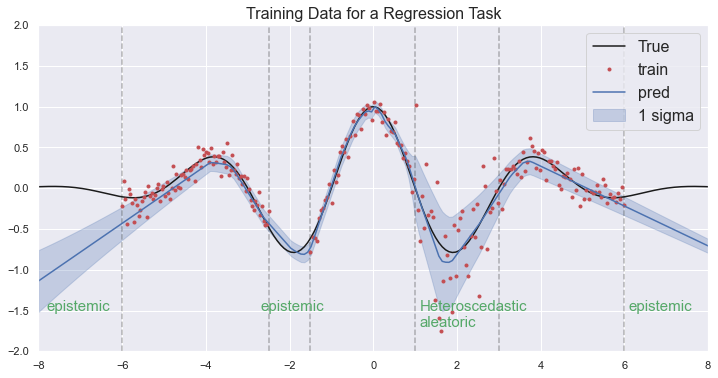

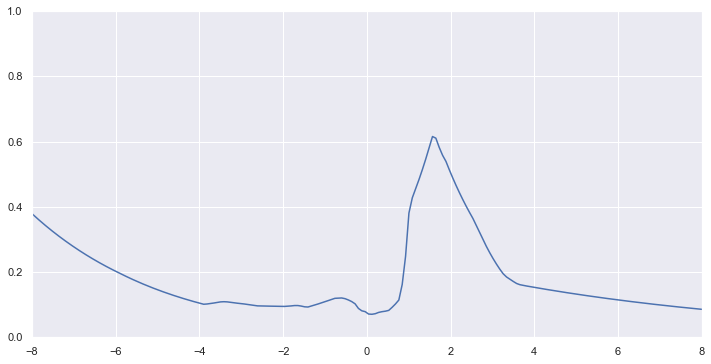

In [32]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred[:,0]+y_sigma[:,0],
                 y_pred[:,0]-y_sigma[:,0],color='b',alpha=.25,label='1 sigma')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-8,8,0.0,1.0])
plt.plot(x_data,y_sigma,'b',label='pred')